In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def logq(x1, x2, eta):
    mean = x2 - eta * x1
    diff = x1 - mean
    return (-0.5 / (2 * eta)) * np.dot(diff, diff) 

def normal_pdf(x, mean, std):
    return (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)


In [3]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()
    acf_ = np.correlate(x, x, mode='full')
    acf_ = acf_[len(acf_) // 2:]
    acf_ /= acf_[0]
    tau = 1 + 2 * np.sum(acf_[1:200])
    return len(x) / tau

def calc_ess(chain):
    vect = []
    for i in range (chain.shape[1]):
        vect.append(ess(chain[:, i]))
    return np.median(vect)


In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [5]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range (steps):
        x_ = x + step * grad_logp(x) + np.sqrt(2 * step) * rng.normal(0, 1, size=d)

        log_pi = logp(x_) - logp(x)

        log_qx = logq(x, x_, step)
        log_qx_ = logq(x_, x, step)
        log_q = log_qx - log_qx_

        log_a = log_pi + log_q
        
        if np.log(rng.uniform()) < min(0, log_a):
            x = x_ 
            accept += 1

        chain[t] = x
        
    return chain, accept / steps

In [23]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанем в точке 3 например

mala_step = 0.5 # тут попробуйте подобрать хороший шаг
mh_scale = 0.84 # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

# Выведите снизу acceptance rate и медианный ESS по размерности d для MH и MALA. Не забудьте обрезать burn-in!
burn_in = int(steps * 0.35)

mh_chain_burned = mh_chain[burn_in:]
mala_chain_burned = mala_chain[burn_in:]

mh_ess = calc_ess(mh_chain_burned)
mala_ess = calc_ess(mala_chain_burned)

print(f"MH acceptance rate: {mh_acc:.5f}")
print(f"MH median ESS: {mh_ess:.5f}\n")

print(f"MALA acceptance rate: {mala_acc:.5f}")
print(f"MALA median ESS: {mala_ess:.5f}")

# print(mh_chain.shape)

MH acceptance rate: 0.21353
MH median ESS: 610.36474

MALA acceptance rate: 0.58403
MALA median ESS: 1603.88277


In [7]:
import matplotlib.pyplot as plt

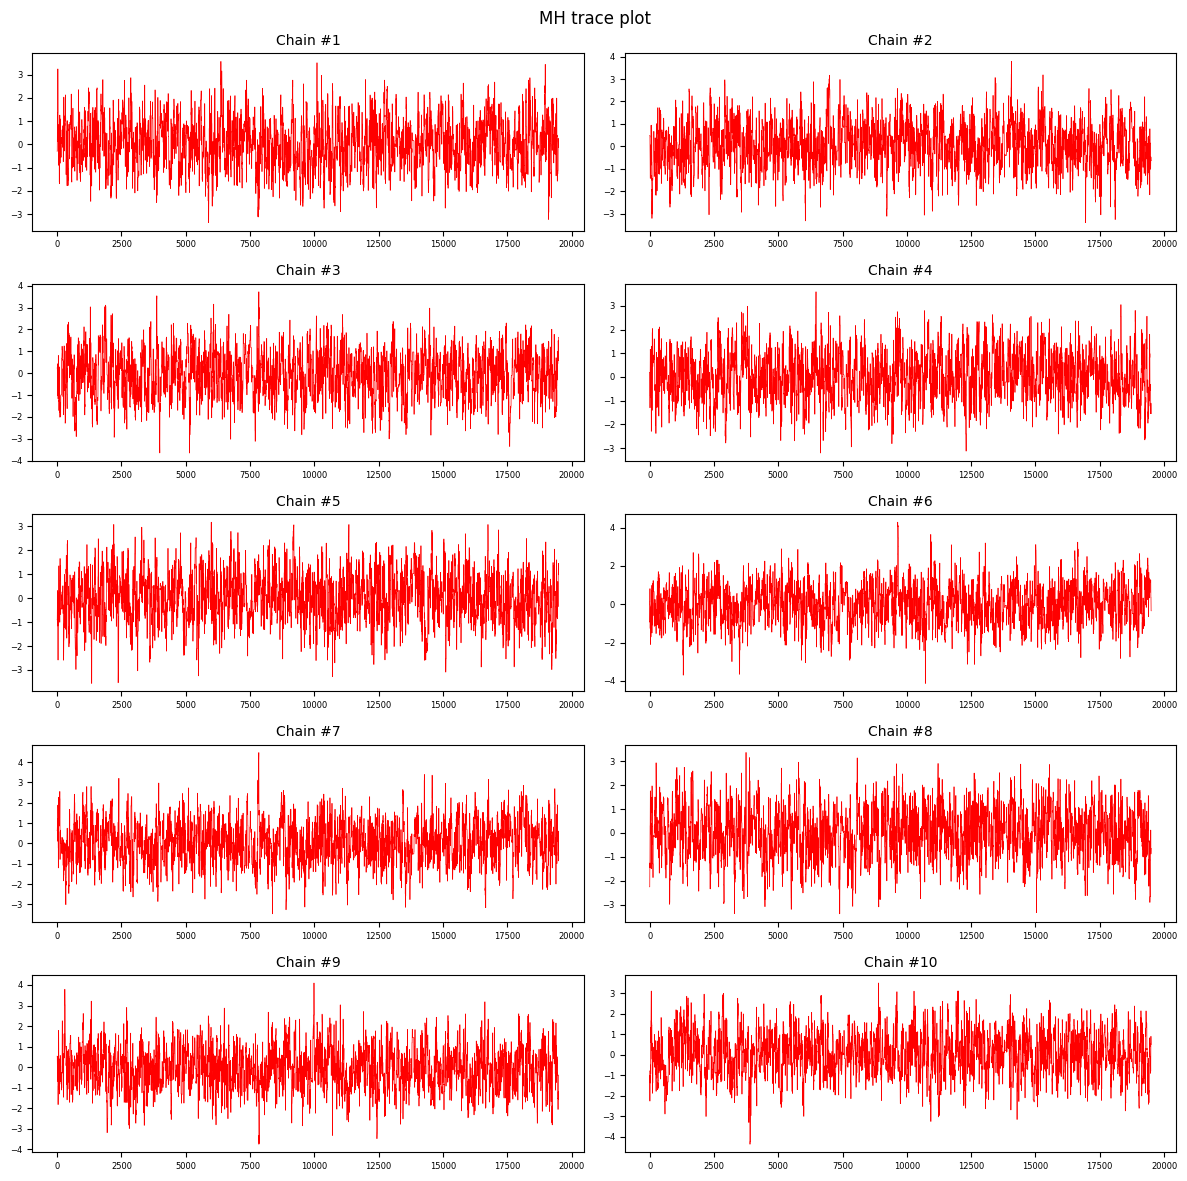

In [24]:
# trace plot (значение цепи vs итерация)

fig, ax = plt.subplots(5, 2, figsize=(12, 12))
for i in range(d):
    row, col = i // 2, i % 2
    ax[row][col].plot(mh_chain_burned[:, i], 'r', linewidth=0.5)
    ax[row][col].tick_params(axis='both', labelsize = 6)
    ax[row][col].set_title(f"Chain #{i + 1}", fontsize = 10)

#plt.xlabel("Iteration (n)", fontsize=3)
#plt.ylabel("X^n", fontsize=3)

plt.suptitle("MH trace plot")
plt.tight_layout()
plt.show()

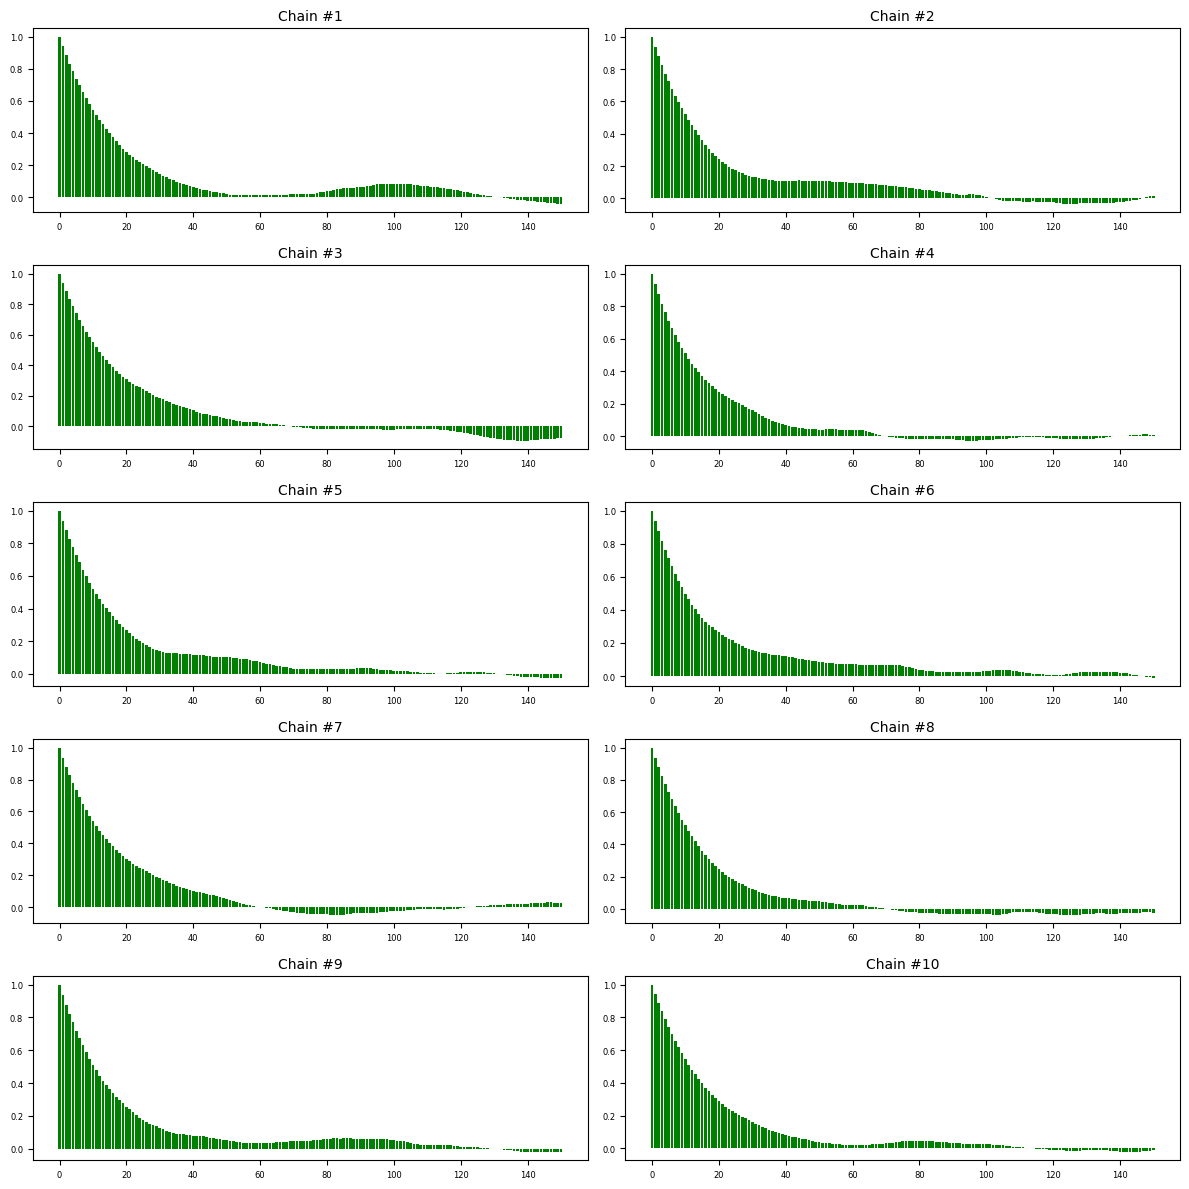

In [25]:
# график автокорреляции (значение ACF vs задержка по времени) 

fig, ax = plt.subplots(5, 2, figsize=(12, 12))
lag = 150
for i in range(d):
    row, col = i // 2, i % 2
    x = mh_chain_burned[:, i]
    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2 : len(acf) // 2 + lag + 1]
    acf /= acf[0]

    ax[row][col].bar(range(len(acf)), acf, color='g')
    
    ax[row][col].tick_params(axis='both', labelsize = 6)
    ax[row][col].set_title(f"Chain #{i + 1}", fontsize = 10)

plt.tight_layout()
plt.show()

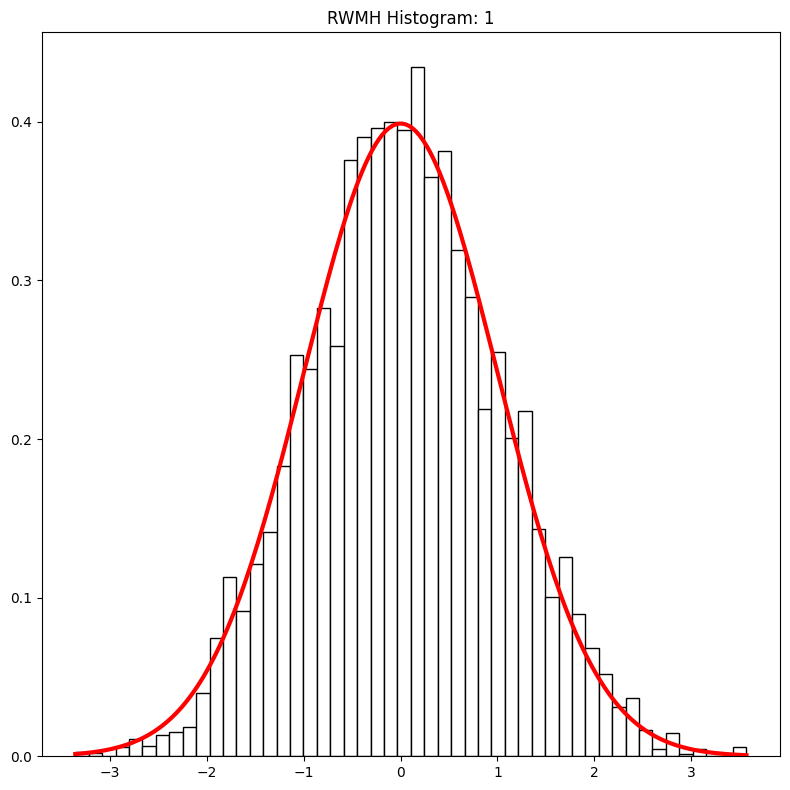

In [26]:
# гистограмма семплов (возьмите какую-то одну размерность)

fig, ax = plt.subplots(figsize=(8, 8))

i = 0 # номер любого куска
row, col = i // 2, i % 2
sample = mh_chain_burned[:, i]

ax.hist(sample, bins=50, density=True, alpha=1, edgecolor='black', color='w')
ax.set_title(f'RWMH Histogram: {i + 1}', fontsize=12)

x_range = np.linspace(sample.min(), sample.max(), 200)
t_pdf = normal_pdf(x_range, 0, 1)
ax.plot(x_range, t_pdf, 'r', linewidth=3)

plt.tight_layout()
plt.show()